In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import optuna
from optuna.samplers import TPESampler
import sqlite3
from datetime import datetime

# display all of the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns',None)

%matplotlib inline

In [2]:
# Path to mock database
SQL_PATH = 'C:/Users/Windows/Downloads/MockDatabase.db'

# Path to model storage location
MODEL_STORAGE_PATH = 'models/'

In [3]:
# Code in the following cells was adapted from: https://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)

    return conn

# Data Analysis

In [5]:
# Read in training data
conn = create_connection(SQL_PATH)

read_query = '''SELECT Age, Sex, ChestPainType, RestingBP, Cholesterol, 
              FastingBS, RestingECG, MaxHR, ExerciseAngina, Oldpeak, ST_Slope, HeartDisease
              FROM heart'''

data_train = pd.read_sql(read_query, conn)
conn.close()

print(data_train.shape)
data_train.head()

(1836, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
# How much data is missing
data_train.isna().sum() / len(data_train) # This will output the proportion of missing values in each column

Age               0.0
Sex               0.0
ChestPainType     0.0
RestingBP         0.0
Cholesterol       0.0
FastingBS         0.0
RestingECG        0.0
MaxHR             0.0
ExerciseAngina    0.0
Oldpeak           0.0
ST_Slope          0.0
HeartDisease      0.0
dtype: float64

In [7]:
# Separate columns by data type for analysis
cat_cols = [col for col in data_train.columns if data_train[col].dtype == np.object]
num_cols = [col for col in data_train.columns if data_train[col].dtype != np.object]
assert len(cat_cols) + len(num_cols) == data_train.shape[1]

C:\Users\Windows\AppData\Local\Temp\ipykernel_13464\2341797596.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat_cols = [col for col in data_train.columns if data_train[col].dtype == np.object]
C:\Users\Windows\AppData\Local\Temp\ipykernel_13464\2341797596.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_cols = [col for col in data_train.columns if data_train[col].dtype != np.object]


Text(0.5, 1.0, 'Feature Cardinality')

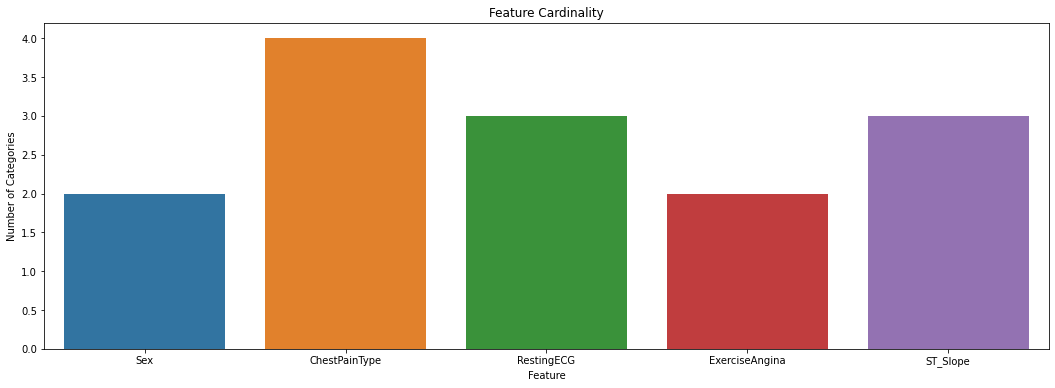

In [8]:
# Look at cadinality of the categorical columns
cards = [len(data_train[col].unique()) for col in cat_cols]

fig,ax = plt.subplots(figsize=(18,6))
sns.barplot(x=cat_cols, y=cards)
ax.set_xlabel('Feature')
ax.set_ylabel('Number of Categories')
ax.set_title('Feature Cardinality')

C:\Users\Windows\Desktop\heart-disease-detection\env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Cholesterol', ylabel='Density'>

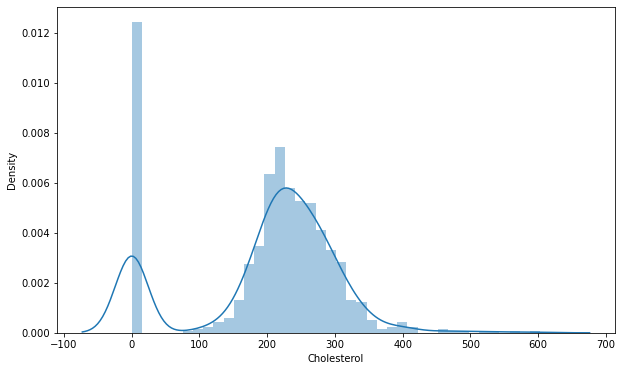

In [9]:
# City development index distribution
fig,ax = plt.subplots(figsize=(10,6))
sns.distplot(data_train['Cholesterol'])

C:\Users\Windows\Desktop\heart-disease-detection\env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='RestingBP', ylabel='Density'>

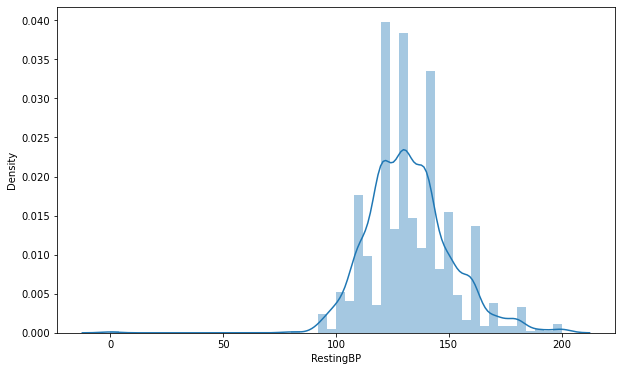

In [10]:
# Training hours distribution
fig,ax = plt.subplots(figsize=(10,6))
sns.distplot(data_train['RestingBP'])

1    0.553377
0    0.446623
Name: HeartDisease, dtype: float64


C:\Users\Windows\Desktop\heart-disease-detection\env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

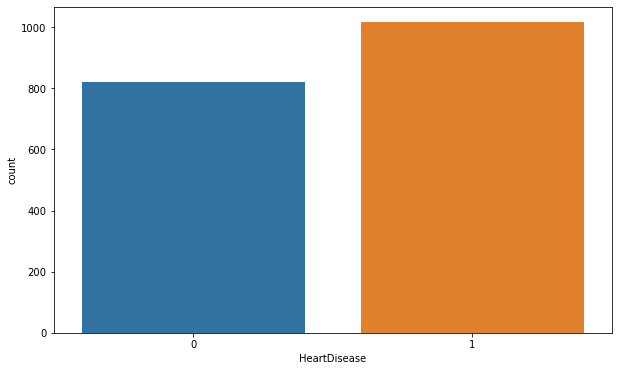

In [11]:
# Target distribution
fig,ax = plt.subplots(figsize=(10,6))
print(data_train['HeartDisease'].value_counts() / len(data_train))
sns.countplot(data_train['HeartDisease'])

# Preprocessing 

In [12]:
# Convert missing values to string
data_train.replace(np.nan,'NaN',inplace=True)
data_train.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [13]:
# Create training and testing data
x, y = data_train.dropna().drop(['HeartDisease'], axis=1), data_train.dropna()['HeartDisease']
    

# Add a random feature to analyze important features
#x['rv'] = np.random.normal(size=len(x))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=13)

print(x_train.shape)
print(x_test.shape)
x_train.head()

(1468, 11)
(368, 11)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
1589,61,M,ASY,138,166,0,LVH,125,Y,3.6,Flat
339,64,F,ASY,95,0,1,Normal,145,N,1.1,Down
608,62,M,ASY,158,170,0,ST,138,Y,0.0,Flat
1099,51,M,ATA,130,224,0,Normal,150,N,0.0,Up
1178,46,M,ATA,140,275,0,Normal,165,Y,0.0,Up


# Initial model training

In [14]:
# Specify index of categotical features in input data
cat_features = [x.columns.get_loc(col) for col in cat_cols]

# Model parameter dict
params = {'iterations':5000,
          'loss_function':'Logloss',
          'depth':4,
          'early_stopping_rounds':20,
          'custom_loss':['AUC', 'Accuracy']}

# Instantiate model
model = CatBoostClassifier(**params)

# Fit model
model.fit(
    x_train,
    y_train,
    cat_features=cat_features,
    eval_set=(x_test, y_test),
    verbose=50,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.0173
0:	learn: 0.6791654	test: 0.6793903	best: 0.6793903 (0)	total: 164ms	remaining: 13m 39s
50:	learn: 0.3860353	test: 0.3978954	best: 0.3978954 (50)	total: 1.01s	remaining: 1m 38s
100:	learn: 0.3185748	test: 0.3355991	best: 0.3355991 (100)	total: 2.01s	remaining: 1m 37s
150:	learn: 0.2903710	test: 0.3159914	best: 0.3159914 (150)	total: 2.92s	remaining: 1m 33s
200:	learn: 0.2735277	test: 0.3075602	best: 0.3075602 (200)	total: 3.76s	remaining: 1m 29s
250:	learn: 0.2594977	test: 0.2994185	best: 0.2994185 (250)	total: 4.44s	remaining: 1m 23s
300:	learn: 0.2495816	test: 0.2946817	best: 0.2946817 (300)	total: 5.08s	remaining: 1m 19s
350:	learn: 0.2416920	test: 0.2919905	best: 0.2919279 (349)	total: 5.75s	remaining: 1m 16s
400:	learn: 0.2319228	test: 0.2881710	best: 0.2881049 (397)	total: 6.46s	remaining: 1m 14s
450:	learn: 0.2240258	test: 0.2848407	best: 0.2848407 (450)	total: 7.14s	remaining: 1m 12s
500:	learn: 0.2155413	test: 0.2805765	best: 0.2805035 (498)	total: 

In [15]:
# Make predictions on test data
preds = model.predict(x_test)

In [16]:
# Evaluate predictions
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       164
           1       0.90      0.95      0.92       204

    accuracy                           0.91       368
   macro avg       0.91      0.91      0.91       368
weighted avg       0.91      0.91      0.91       368

[[142  22]
 [ 11 193]]


<AxesSubplot:xlabel='importance', ylabel='feature'>

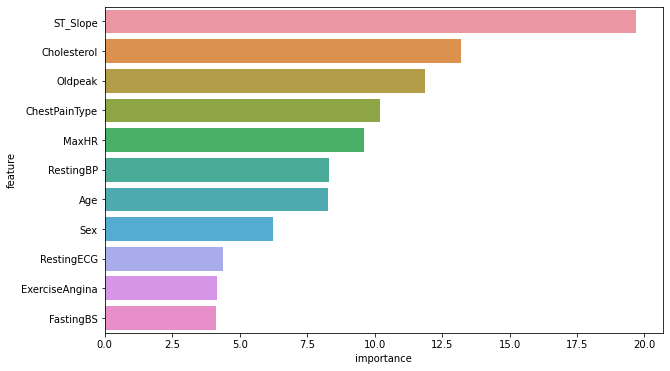

In [17]:
fig,ax = plt.subplots(figsize=(10,6))
feature_importance_data = pd.DataFrame({'feature':model.feature_names_, 'importance':model.feature_importances_})
feature_importance_data.sort_values('importance', ascending=False, inplace=True)
sns.barplot(x='importance', y='feature', data=feature_importance_data)

# Hyperparameter tuning

In [18]:
def classification_objective(trial):

    params = {
        "loss_function":"Logloss",
        'custom_loss':['Accuracy'],
        #"learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20)}
    
    if params["bootstrap_type"] == "Bayesian":
        
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        
    elif params["bootstrap_type"] == "Bernoulli":
        
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cv_data = cv(
    params = params,
    pool = Pool(x, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=False,
    stratified=False,
    verbose=False)
    
    return cv_data['test-Accuracy-mean'].values[-1]

In [19]:
classification_study = optuna.create_study(sampler=TPESampler(), direction="maximize")
classification_study.optimize(classification_objective, n_trials=20, timeout=600) 
trial = classification_study.best_trial

print(f"Highest Accuracy: {trial.value}")
print("Optimal Parameters:")
for key, val in trial.params.items():
    print(f"{key}:{val}")

[I 2022-06-12 18:21:00,848] A new study created in memory with name: no-name-ee70405d-5056-423a-be0b-104fd0f54e13


Training on fold [0/5]

bestTest = 0.1487994874
bestIteration = 991

Training on fold [1/5]

bestTest = 0.07641179741
bestIteration = 997

Training on fold [2/5]

bestTest = 0.1413506567
bestIteration = 999

Training on fold [3/5]

bestTest = 0.1518470699
bestIteration = 999

Training on fold [4/5]


[I 2022-06-12 18:21:10,999] Trial 0 finished with value: 0.964050467954034 and parameters: {'l2_leaf_reg': 0.5197210529705947, 'colsample_bylevel': 0.11547524627770017, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 2, 'one_hot_max_size': 20, 'subsample': 0.5786486263876396}. Best is trial 0 with value: 0.964050467954034.



bestTest = 0.1103514349
bestIteration = 996

Training on fold [0/5]

bestTest = 0.196252424
bestIteration = 999

Training on fold [1/5]

bestTest = 0.1300315604
bestIteration = 999

Training on fold [2/5]

bestTest = 0.1785102424
bestIteration = 998

Training on fold [3/5]

bestTest = 0.1957779071
bestIteration = 988

Training on fold [4/5]


[I 2022-06-12 18:21:41,735] Trial 1 finished with value: 0.9422654306361805 and parameters: {'l2_leaf_reg': 0.22580483274567623, 'colsample_bylevel': 0.39460791113460714, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 19, 'one_hot_max_size': 6, 'subsample': 0.5697930931647676}. Best is trial 0 with value: 0.964050467954034.



bestTest = 0.1593661963
bestIteration = 999

Training on fold [0/5]

bestTest = 0.09977962616
bestIteration = 342

Training on fold [1/5]

bestTest = 0.008920709989
bestIteration = 925

Training on fold [2/5]

bestTest = 0.06941653121
bestIteration = 452

Training on fold [3/5]

bestTest = 0.07702383129
bestIteration = 453

Training on fold [4/5]


[I 2022-06-12 18:22:16,086] Trial 2 finished with value: 0.9793093235398651 and parameters: {'l2_leaf_reg': 0.24378781708280897, 'colsample_bylevel': 0.4422943073348515, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 19, 'subsample': 0.7480193656792052}. Best is trial 2 with value: 0.9793093235398651.



bestTest = 0.04469536447
bestIteration = 592

Training on fold [0/5]

bestTest = 0.243409024
bestIteration = 999

Training on fold [1/5]

bestTest = 0.1869572857
bestIteration = 999

Training on fold [2/5]

bestTest = 0.227614185
bestIteration = 998

Training on fold [3/5]

bestTest = 0.2334102828
bestIteration = 999

Training on fold [4/5]


[I 2022-06-12 18:22:40,017] Trial 3 finished with value: 0.9232051889586541 and parameters: {'l2_leaf_reg': 0.04110935309725955, 'colsample_bylevel': 0.15090565425551428, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 9, 'subsample': 0.27286875064136806}. Best is trial 2 with value: 0.9793093235398651.



bestTest = 0.2100512949
bestIteration = 999

Training on fold [0/5]

bestTest = 0.1181468399
bestIteration = 313

Training on fold [1/5]

bestTest = 0.007865155679
bestIteration = 498

Training on fold [2/5]

bestTest = 0.06113628024
bestIteration = 290

Training on fold [3/5]

bestTest = 0.07698630961
bestIteration = 290

Training on fold [4/5]


[I 2022-06-12 18:23:05,780] Trial 4 finished with value: 0.9771294870276034 and parameters: {'l2_leaf_reg': 0.01854962549326124, 'colsample_bylevel': 0.6694324126608565, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 16, 'one_hot_max_size': 4}. Best is trial 2 with value: 0.9793093235398651.



bestTest = 0.05377011771
bestIteration = 370

Training on fold [0/5]

bestTest = 0.1985284142
bestIteration = 999

Training on fold [1/5]

bestTest = 0.1187580493
bestIteration = 999

Training on fold [2/5]

bestTest = 0.1754255647
bestIteration = 992

Training on fold [3/5]

bestTest = 0.1782618224
bestIteration = 998

Training on fold [4/5]


[I 2022-06-12 18:23:13,801] Trial 5 finished with value: 0.94280890889705 and parameters: {'l2_leaf_reg': 0.03199756794702241, 'colsample_bylevel': 0.13922726710405042, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 20, 'one_hot_max_size': 16, 'subsample': 0.32599965794435076}. Best is trial 2 with value: 0.9793093235398651.



bestTest = 0.1520945291
bestIteration = 999

Training on fold [0/5]

bestTest = 0.3039166041
bestIteration = 998

Training on fold [1/5]

bestTest = 0.2507265944
bestIteration = 999

Training on fold [2/5]

bestTest = 0.2858562168
bestIteration = 994

Training on fold [3/5]

bestTest = 0.2986462178
bestIteration = 990

Training on fold [4/5]


[I 2022-06-12 18:23:22,509] Trial 6 finished with value: 0.8943475299135175 and parameters: {'l2_leaf_reg': 0.018617871161804224, 'colsample_bylevel': 0.6768958222044658, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 3, 'one_hot_max_size': 14, 'bagging_temperature': 2.2767981044472982}. Best is trial 2 with value: 0.9793093235398651.



bestTest = 0.266041588
bestIteration = 999

Training on fold [0/5]

bestTest = 0.2465027341
bestIteration = 998

Training on fold [1/5]

bestTest = 0.1903085565
bestIteration = 993

Training on fold [2/5]

bestTest = 0.2204509307
bestIteration = 999

Training on fold [3/5]

bestTest = 0.2373353406
bestIteration = 998

Training on fold [4/5]


[I 2022-06-12 18:23:51,068] Trial 7 finished with value: 0.921571792441654 and parameters: {'l2_leaf_reg': 0.05196401395594459, 'colsample_bylevel': 0.3487451699448376, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 20, 'one_hot_max_size': 16, 'bagging_temperature': 8.011859508162637}. Best is trial 2 with value: 0.9793093235398651.



bestTest = 0.2021075402
bestIteration = 999

Training on fold [0/5]

bestTest = 0.3273815226
bestIteration = 978

Training on fold [1/5]

bestTest = 0.2619008466
bestIteration = 998

Training on fold [2/5]

bestTest = 0.3018044894
bestIteration = 999

Training on fold [3/5]

bestTest = 0.3113053018
bestIteration = 999

Training on fold [4/5]


[I 2022-06-12 18:24:10,685] Trial 8 finished with value: 0.8840021916834498 and parameters: {'l2_leaf_reg': 0.47607997328032026, 'colsample_bylevel': 0.04767888915669937, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 12, 'one_hot_max_size': 15, 'subsample': 0.9780409230100413}. Best is trial 2 with value: 0.9793093235398651.



bestTest = 0.2930048725
bestIteration = 999

Training on fold [0/5]

bestTest = 0.3534594719
bestIteration = 999

Training on fold [1/5]

bestTest = 0.2963675978
bestIteration = 988

Training on fold [2/5]

bestTest = 0.3221687498
bestIteration = 990

Training on fold [3/5]

bestTest = 0.3349175727
bestIteration = 999

Training on fold [4/5]


[I 2022-06-12 18:24:16,782] Trial 9 finished with value: 0.8725580499940765 and parameters: {'l2_leaf_reg': 0.09967206374475279, 'colsample_bylevel': 0.060682609500150385, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 8, 'one_hot_max_size': 12}. Best is trial 2 with value: 0.9793093235398651.



bestTest = 0.3303775997
bestIteration = 992

Training on fold [0/5]

bestTest = 0.1049647163
bestIteration = 648

Training on fold [1/5]

bestTest = 0.01473969116
bestIteration = 999

Training on fold [2/5]

bestTest = 0.06698413717
bestIteration = 755

Training on fold [3/5]

bestTest = 0.09447988991
bestIteration = 932

Training on fold [4/5]


[I 2022-06-12 18:24:35,389] Trial 10 finished with value: 0.9716798957469495 and parameters: {'l2_leaf_reg': 0.17883233377859195, 'colsample_bylevel': 0.9723843610698428, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 8, 'one_hot_max_size': 18, 'bagging_temperature': 9.994192954414476}. Best is trial 2 with value: 0.9793093235398651.



bestTest = 0.06885382686
bestIteration = 867

Training on fold [0/5]

bestTest = 0.1666625099
bestIteration = 886

Training on fold [1/5]

bestTest = 0.02043727373
bestIteration = 953

Training on fold [2/5]

bestTest = 0.07976586922
bestIteration = 393

Training on fold [3/5]

bestTest = 0.1289810649
bestIteration = 746

Training on fold [4/5]


[I 2022-06-12 18:26:53,177] Trial 11 finished with value: 0.9727698140030802 and parameters: {'l2_leaf_reg': 0.012436792287039674, 'colsample_bylevel': 0.6662007911075584, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 15, 'one_hot_max_size': 2}. Best is trial 2 with value: 0.9793093235398651.



bestTest = 0.06561392909
bestIteration = 384

Training on fold [0/5]

bestTest = 0.1404742783
bestIteration = 999

Training on fold [1/5]

bestTest = 0.02503029172
bestIteration = 961

Training on fold [2/5]

bestTest = 0.0847054914
bestIteration = 671

Training on fold [3/5]

bestTest = 0.1107577334
bestIteration = 944

Training on fold [4/5]


[I 2022-06-12 18:28:45,791] Trial 12 finished with value: 0.9733132922639497 and parameters: {'l2_leaf_reg': 0.1262107362415816, 'colsample_bylevel': 0.6418360292015001, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 15, 'one_hot_max_size': 2}. Best is trial 2 with value: 0.9793093235398651.



bestTest = 0.05241092919
bestIteration = 895

Training on fold [0/5]

bestTest = 0.104749615
bestIteration = 369

Training on fold [1/5]

bestTest = 0.01198703133
bestIteration = 996

Training on fold [2/5]

bestTest = 0.06038413993
bestIteration = 366

Training on fold [3/5]

bestTest = 0.08554288768
bestIteration = 287

Training on fold [4/5]


[I 2022-06-12 18:29:52,613] Trial 13 finished with value: 0.9803992417959957 and parameters: {'l2_leaf_reg': 0.30512826788543596, 'colsample_bylevel': 0.9254423408217074, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 16, 'one_hot_max_size': 8}. Best is trial 13 with value: 0.9803992417959957.



bestTest = 0.04368150769
bestIteration = 455

Training on fold [0/5]

bestTest = 0.09386924471
bestIteration = 476

Training on fold [1/5]

bestTest = 0.01259992956
bestIteration = 995

Training on fold [2/5]

bestTest = 0.06461523114
bestIteration = 508

Training on fold [3/5]

bestTest = 0.08531232388
bestIteration = 581

Training on fold [4/5]


[I 2022-06-12 18:30:50,202] Trial 14 finished with value: 0.9782164435493425 and parameters: {'l2_leaf_reg': 0.8488931159736615, 'colsample_bylevel': 0.9737904072718172, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 9, 'one_hot_max_size': 9}. Best is trial 13 with value: 0.9803992417959957.



bestTest = 0.05165690362
bestIteration = 903

Training on fold [0/5]

bestTest = 0.09826834463
bestIteration = 309

Training on fold [1/5]

bestTest = 0.01253462702
bestIteration = 985

Training on fold [2/5]

bestTest = 0.0526304231
bestIteration = 340

Training on fold [3/5]

bestTest = 0.08395404363
bestIteration = 300

Training on fold [4/5]


[I 2022-06-12 18:31:43,309] Trial 15 finished with value: 0.9793034000710816 and parameters: {'l2_leaf_reg': 0.31025954294715385, 'colsample_bylevel': 0.8432371631179828, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 6, 'one_hot_max_size': 8, 'subsample': 0.908955967658458}. Best is trial 13 with value: 0.9803992417959957.



bestTest = 0.05337716709
bestIteration = 322

Highest Accuracy: 0.9803992417959957
Optimal Parameters:
l2_leaf_reg:0.30512826788543596
colsample_bylevel:0.9254423408217074
depth:10
boosting_type:Plain
bootstrap_type:MVS
min_data_in_leaf:16
one_hot_max_size:8


In [20]:
trial.params

{'l2_leaf_reg': 0.30512826788543596,
 'colsample_bylevel': 0.9254423408217074,
 'depth': 10,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'min_data_in_leaf': 16,
 'one_hot_max_size': 8}

# Fit final model using new parameters

In [21]:
new_params = trial.params.copy()
new_params['loss_function'] = 'Logloss'
new_params['custom_loss'] = ['AUC','Accuracy']

cv_data = cv(
        params = new_params,
        pool = Pool(x, label=y, cat_features=cat_features),
        fold_count=5,
        shuffle=True,
        partition_random_seed=0,
        plot=False,
        stratified=False,
        verbose=False)

cv_data

Training on fold [0/5]

bestTest = 0.104749615
bestIteration = 369

Training on fold [1/5]

bestTest = 0.01198703133
bestIteration = 996

Training on fold [2/5]

bestTest = 0.06038413993
bestIteration = 366

Training on fold [3/5]

bestTest = 0.08554288768
bestIteration = 287

Training on fold [4/5]

bestTest = 0.04368150769
bestIteration = 455



,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std,test-Accuracy-mean,test-Accuracy-std,train-Accuracy-mean,train-Accuracy-std
0,0,0.648598,0.000612,0.644550,0.001606,0.949977,0.007862,0.876916,0.018222,0.910676,0.006770
1,1,0.615640,0.001964,0.608332,0.001585,0.963854,0.007795,0.898158,0.014901,0.927424,0.005825
2,2,0.578762,0.003692,0.566618,0.001472,0.969503,0.006744,0.907410,0.009202,0.941177,0.005500
3,3,0.548064,0.006247,0.532778,0.004039,0.971994,0.007266,0.912860,0.013842,0.947984,0.004246
4,4,0.518406,0.006578,0.499818,0.004606,0.973270,0.009443,0.917225,0.019796,0.952069,0.004166
...,...,...,...,...,...,...,...,...,...,...,...
995,995,0.063532,0.037691,0.001364,0.000038,0.996646,0.003996,0.980399,0.010596,1.000000,0.000000
996,996,0.063533,0.037691,0.001363,0.000039,0.996646,0.003996,0.980399,0.010596,1.000000,0.000000
997,997,0.063522,0.037691,0.001362,0.000040,0.996646,0.003996,0.980399,0.010596,1.000000,0.000000
998,998,0.063522,0.037691,0.001362,0.000040,0.996646,0.003996,0.980399,0.010596,1.000000,0.000000


In [22]:
final_params = new_params.copy()
final_params['iterations'] = np.argmax(cv_data['test-Accuracy-mean'])
final_params['cat_features'] = cat_features

final_model = CatBoostClassifier(**final_params)

final_model.fit(x,y,verbose=100)

0:	learn: 0.6735545	total: 14.6ms	remaining: 2.32s
100:	learn: 0.1478351	total: 969ms	remaining: 566ms
159:	learn: 0.0900104	total: 1.59s	remaining: 0us


In [23]:
# Export model
model_name = f'heart_disease_model'
final_model.save_model('heart_disease_model')